In [1]:
import cell2cell as c2c
import scanpy as sc

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

%matplotlib inline

# Data

**RNA-seq data**

In this case is a published dataset of ~14000 IFN-beta treated and control PBMCs from 8 donors (GSE96583; see Kang et al.). (obtained from: https://scelvis.readthedocs.io/en/latest/tutorial_analysis.html)

Download this dataset here: https://files.figshare.com/18037739/pbmc.h5ad

In [2]:
rnaseq = sc.read_h5ad('pbmc.h5ad')

In [3]:
rnaseq

AnnData object with n_obs × n_vars = 13836 × 14053
    obs: 'n_genes', 'n_counts', 'orig_ident', 'stim', 'cluster', 'Donor'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled'
    uns: 'about_readme', 'about_short_title', 'about_title', 'marker_avg_logFC', 'marker_cluster', 'marker_gene', 'marker_p_val_adj'
    obsm: 'X_tsne'

**Protein-Protein Interactions or Ligand-Receptor Pairs**

In this case, we use a list of LR pairs published with CellChat (Jin et al. 2021, Nature Communications).

In [4]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')

In [5]:
lr_pairs.head()

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,ligand_symbol,receptor_symbol,ligand_ensembl,receptor_ensembl,interaction_symbol,interaction_ensembl
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2),TGFB1,TGFBR1&TGFBR2,ENSG00000105329,ENSG00000106799&ENSG00000163513,TGFB1^TGFBR1&TGFBR2,ENSG00000105329^ENSG00000106799&ENSG00000163513
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2),TGFB2,TGFBR1&TGFBR2,ENSG00000092969,ENSG00000106799&ENSG00000163513,TGFB2^TGFBR1&TGFBR2,ENSG00000092969^ENSG00000106799&ENSG00000163513
2,TGFB3_TGFBR1_TGFBR2,TGFb,TGFB3,TGFbR1_R2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB3 - (TGFBR1+TGFBR2),TGFB3,TGFBR1&TGFBR2,ENSG00000119699,ENSG00000106799&ENSG00000163513,TGFB3^TGFBR1&TGFBR2,ENSG00000119699^ENSG00000106799&ENSG00000163513
3,TGFB1_ACVR1B_TGFBR2,TGFb,TGFB1,ACVR1B_TGFbR2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,TGFB1 - (ACVR1B+TGFBR2),TGFB1,ACVR1B&TGFBR2,ENSG00000105329,ENSG00000135503&ENSG00000163513,TGFB1^ACVR1B&TGFBR2,ENSG00000105329^ENSG00000135503&ENSG00000163513
4,TGFB1_ACVR1C_TGFBR2,TGFb,TGFB1,ACVR1C_TGFbR2,TGFb agonist,TGFb antagonist,NaN,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,TGFB1 - (ACVR1C+TGFBR2),TGFB1,ACVR1C&TGFBR2,ENSG00000105329,ENSG00000123612&ENSG00000163513,TGFB1^ACVR1C&TGFBR2,ENSG00000105329^ENSG00000123612&ENSG00000163513


In [6]:
# interaction columns:
int_columns = ('ligand_symbol', 'receptor_symbol')

Remove bidirectionality in the list of ligand-receptor pairs. That is, remove repeated interactions where both interactions are the same but in different order:

From this list:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |
| Protein B | Protein A |

We will have:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |

In [7]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [8]:
lr_pairs.shape

(1988, 17)

**Generate a dictionary with function info for each LR pairs. Keys are LIGAND_NAME^RECEPTOR_NAME and values are the function in the annotation column in the dataframe containing ligand-receptor pairs.**

In [9]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

**Metadata**

Metadata for the single cells

In [10]:
meta = rnaseq.obs.copy()

In [11]:
meta.head()

,n_genes,n_counts,orig_ident,stim,cluster,Donor
index,,,,,,
CTRL_AAACATACATTTCC.1,878.0,3018.0,CTRL,CTRL,CD14 Mono,SNG-1016
CTRL_AAACATACCAGAAA.1,713.0,2481.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACCTCGCT.1,850.0,3420.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACGGCATT.1,558.0,1582.0,CTRL,CTRL,CD14 Mono,SNG-1015
CTRL_AAACATTGCTTCGC.1,669.0,2536.0,CTRL,CTRL,CD14 Mono,SNG-1256


# Tensor-cell2cell Analysis

**Organize data to create tensor**

**In this dataset, contexts correspond to donors in both conditions before and after treatment**, so we need to arrange their expression matrices and then preprocess them.

First, generate a dictionary indicating what condition is associated to each sample

In [12]:
meta['Context'] = meta.apply(lambda row: row['Donor'] + '_' + row['stim'], axis=1)

context_dict = dict()

for stim, df in meta.groupby('stim'):
    for donor in df.Context.unique():
        context_dict[donor] = stim

In [13]:
context_dict

{'SNG-1016_CTRL': 'CTRL',
 'SNG-1256_CTRL': 'CTRL',
 'SNG-1015_CTRL': 'CTRL',
 'SNG-101_CTRL': 'CTRL',
 'SNG-1488_CTRL': 'CTRL',
 'SNG-1244_CTRL': 'CTRL',
 'SNG-1039_CTRL': 'CTRL',
 'SNG-107_CTRL': 'CTRL',
 'SNG-101_STIM': 'STIM',
 'SNG-1016_STIM': 'STIM',
 'SNG-1244_STIM': 'STIM',
 'SNG-1488_STIM': 'STIM',
 'SNG-1015_STIM': 'STIM',
 'SNG-1256_STIM': 'STIM',
 'SNG-1039_STIM': 'STIM',
 'SNG-107_STIM': 'STIM'}

Sort contexts to have them all together by condition, but donors in the same order within each condition

In [14]:
context_names = meta.Donor.unique().tolist()
context_names = [c + '_CTRL' for c in context_names] + [c + '_STIM' for c in context_names]

In [15]:
context_names

['SNG-1016_CTRL',
 'SNG-1256_CTRL',
 'SNG-1015_CTRL',
 'SNG-101_CTRL',
 'SNG-1488_CTRL',
 'SNG-1244_CTRL',
 'SNG-1039_CTRL',
 'SNG-107_CTRL',
 'SNG-1016_STIM',
 'SNG-1256_STIM',
 'SNG-1015_STIM',
 'SNG-101_STIM',
 'SNG-1488_STIM',
 'SNG-1244_STIM',
 'SNG-1039_STIM',
 'SNG-107_STIM']

**Generate list of RNA-seq data for each context**

In [16]:
rnaseq_matrices = []

for context in tqdm(context_names):
        meta_context = meta.loc[meta['Context'] == context]
        cells = list(meta_context.index)
        
        meta_context.index.name = 'barcode'
        tmp_data = rnaseq[cells]
        # Keep genes in each sample with at least 3 single cells expressing it
        sc.pp.filter_genes(tmp_data, min_cells=3)
        
        # Aggregate gene expression of single cells into cell types
        exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data.to_df(),
                                                          metadata=meta_context,
                                                          barcode_col='barcode',
                                                          celltype_col='cluster',
                                                          method='nn_cell_fraction',
                                                         )
        
        rnaseq_matrices.append(exp_df)

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set a

**Build 4D-Communication Tensor**

```how='inner'``` is used to keep only cell types and genes that are across all contexts.

```complex_sep='&'``` is used to specify that the list of ligand-receptor pairs contains protein complexes and that subunits are separated by '&'. If the list does not have complexes, use ```complex_sep=None``` instead.

In [17]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=rnaseq_matrices,
                                      ppi_data=lr_pairs,
                                      context_names=context_names,
                                      how='inner',
                                      complex_sep='&',
                                      interaction_columns=int_columns,
                                      communication_score='expression_mean',
                                     )

Getting expression values for protein complexes
Building tensor for the provided context


(# Contexts, # LR pairs, # Sender cell types, # Receiver cell types) contained in the tensor, after all the preprocessing

In [18]:
tensor.tensor.shape

(16, 46, 12, 12)

**Generate a list containing metadata for each tensor order/dimension - Later used for coloring factor plots**

In [19]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

**Elbow analysis for selecting Rank for Tensor-Factorization**


The rank at the elbow is: 8


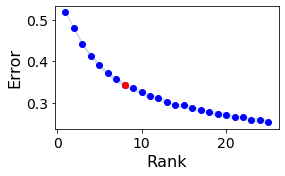

In [20]:
fig, error = tensor.elbow_rank_selection(upper_rank=25,
                                         runs=10,
                                         init='random',
                                         automatic_elbow=True,
                                         random_state=888,
                                         filename=None # Put a path (e.g. ./Elbow.png) to save the figure
                                        )

**Tensor decomposition**

In [21]:
tensor.compute_tensor_factorization(rank=tensor.rank,
                                    init='random',
                                    random_state=888)

# Results

**Plot factors**

Color palettes for each dimension

In [22]:
cmaps = ['plasma', 'Dark2_r', 'tab20', 'tab20']

Plot factor loadings

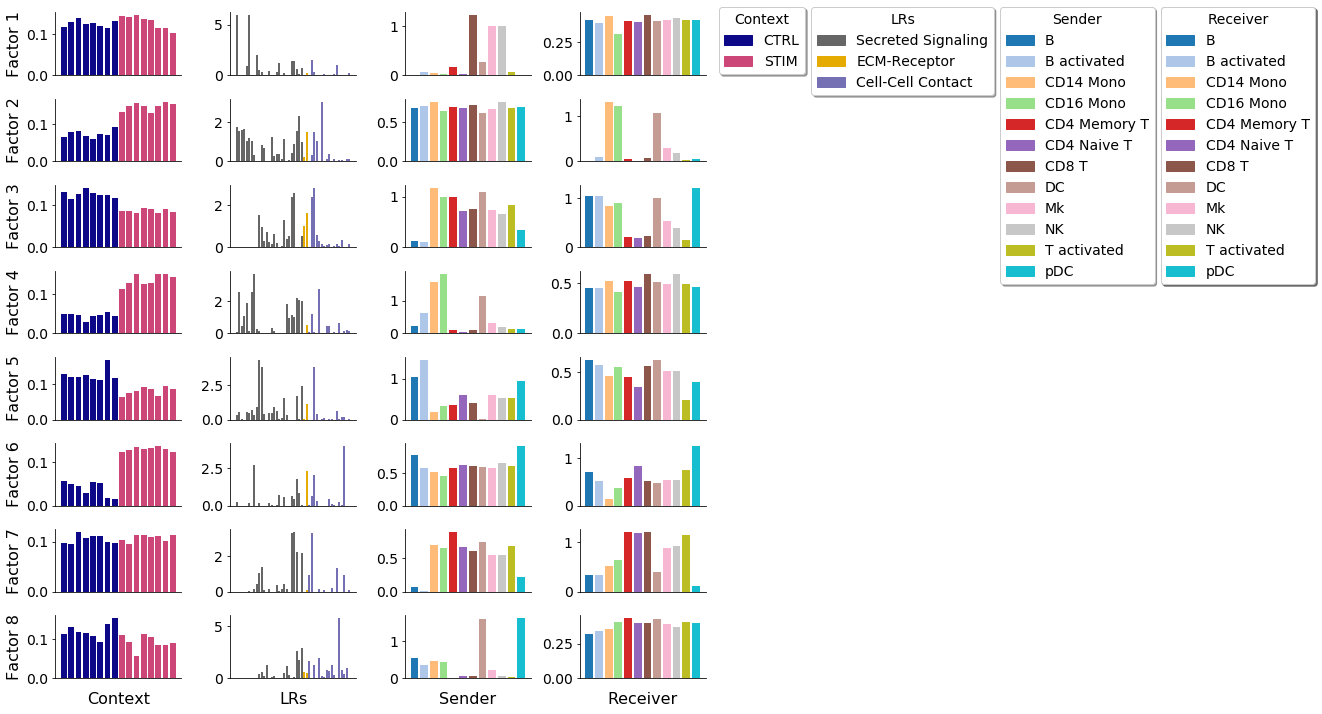

In [23]:
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             metadata = meta_tf,
                                             sample_col='Element',
                                             group_col='Category',
                                             meta_cmaps=cmaps,
                                             fontsize=14,
                                             filename=None # Put a path (e.g. ./TF.png) to save the figure
                                            )

**Top-5 LR pairs in each factor**

In [24]:
for i in range(tensor.rank):
    print(tensor.get_top_factor_elements('LRs', 'Factor {}'.format(i+1), 5))
    print('')

CCL5^CCR5          5.901522
CCL5^CCR1          5.899030
PF4^CXCR3          1.947483
ANXA1^FPR2&FPR3    1.456190
ANXA1^FPR2         1.422181
Name: Factor 1, dtype: float64

CD99^PILRA       3.063714
LGALS9^HAVCR2    2.308333
CCL5^CCR1        1.770495
CCL7^CCR1        1.667017
CCL3L1^CCR1      1.615941
Name: Factor 2, dtype: float64

APP^CD74           2.824500
ANXA1^FPR1         2.573699
ANXA1^FPR2         2.374692
ANXA1^FPR2&FPR3    2.360974
THBS1^CD47         1.610081
Name: Factor 3, dtype: float64

CXCL10^CXCR3    3.651500
CD86^CD28       2.704713
CCL3^CCR5       2.553773
CCL3^CCR1       2.541010
LGALS9^PTPRC    2.178440
Name: Factor 4, dtype: float64

MIF^CD74&CXCR4    4.326332
APP^CD74          3.830060
MIF^CD74&CD44     3.780287
LGALS9^CD44       2.435904
LGALS9^PTPRC      1.682470
Name: Factor 5, dtype: float64

SELPLG^SELL     3.953971
CXCL10^CXCR3    2.664913
THBS1^CD47      2.279962
APP^CD74        2.038908
LGALS9^PTPRC    1.781442
Name: Factor 6, dtype: float64

ANXA1^FPR1   

**Export an excel with all loadings**

In [25]:
#tensor.export_factor_loadings('Loadings.xlsx')